# Planet: Understanding the Amazon deforestation from Space challenge

Special thanks to the kernel contributors of this challenge (especially @anokas and @Kaggoo) who helped me find a starting point for this notebook.

**If you found this notebook useful some upvotes would be greatly appreciated! :) **

Start by adding the helper files to the python path

In [1]:
import sys

sys.path.append('../src')
sys.path.append('../tests')

## Import required modules

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras_tqdm import TQDMNotebookCallback

import data_helper
from keras_helper import AmazonKerasClassifier

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


Print tensorflow version for reuse (the Keras module is used directly from the tensorflow framework)

In [3]:
tf.__version__

'1.1.0'

## Inspect image labels
Visualize what the training set looks like

In [4]:
train_jpeg_dir, test_jpeg_dir, test_jpeg_additional, train_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Each image can be tagged with multiple tags, lets list all uniques tags

In [5]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'cloudy', 'cultivation', 'haze', 'water', 'conventional_mine', 'slash_burn', 'artisinal_mine', 'habitation', 'primary', 'clear', 'selective_logging', 'road', 'agriculture', 'partly_cloudy', 'blow_down', 'blooming', 'bare_ground'}


### Repartition of each labels

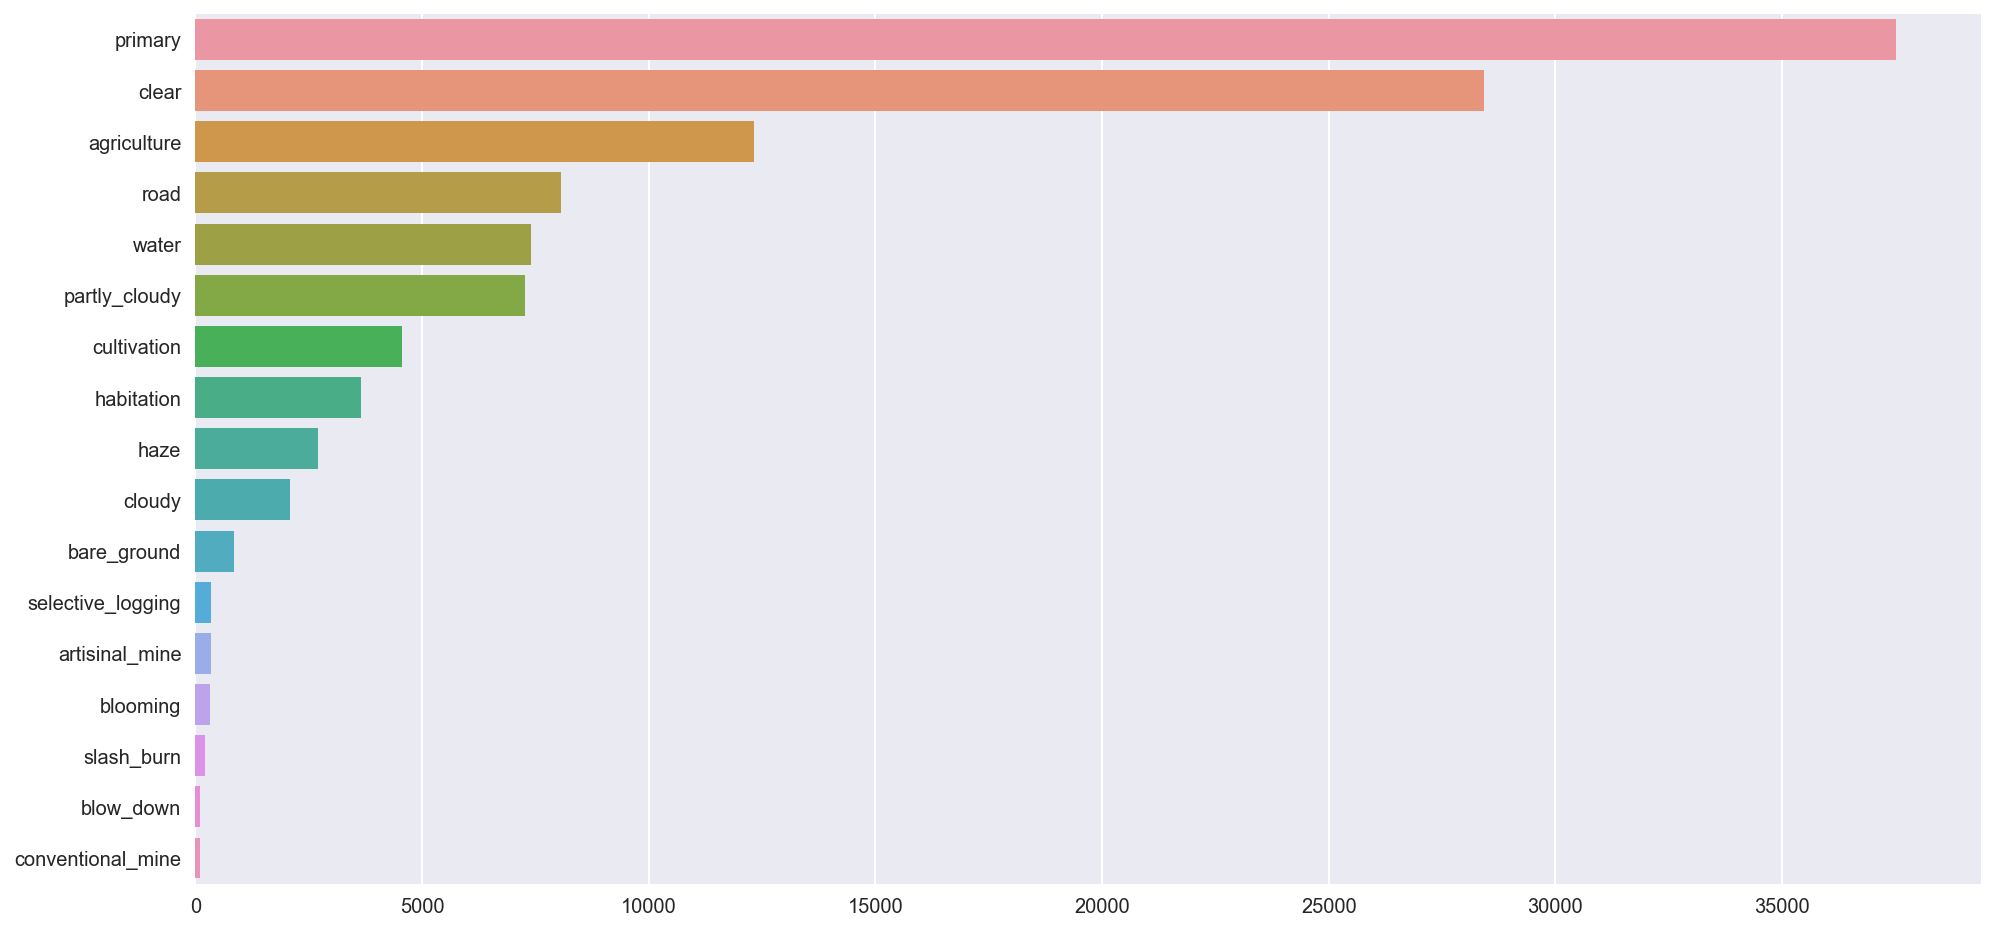

In [6]:
# Histogram of label instances
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

## Images
Visualize some chip images to know what we are dealing with.
Lets vizualise 1 chip for the 17 images to get a sense of their differences.

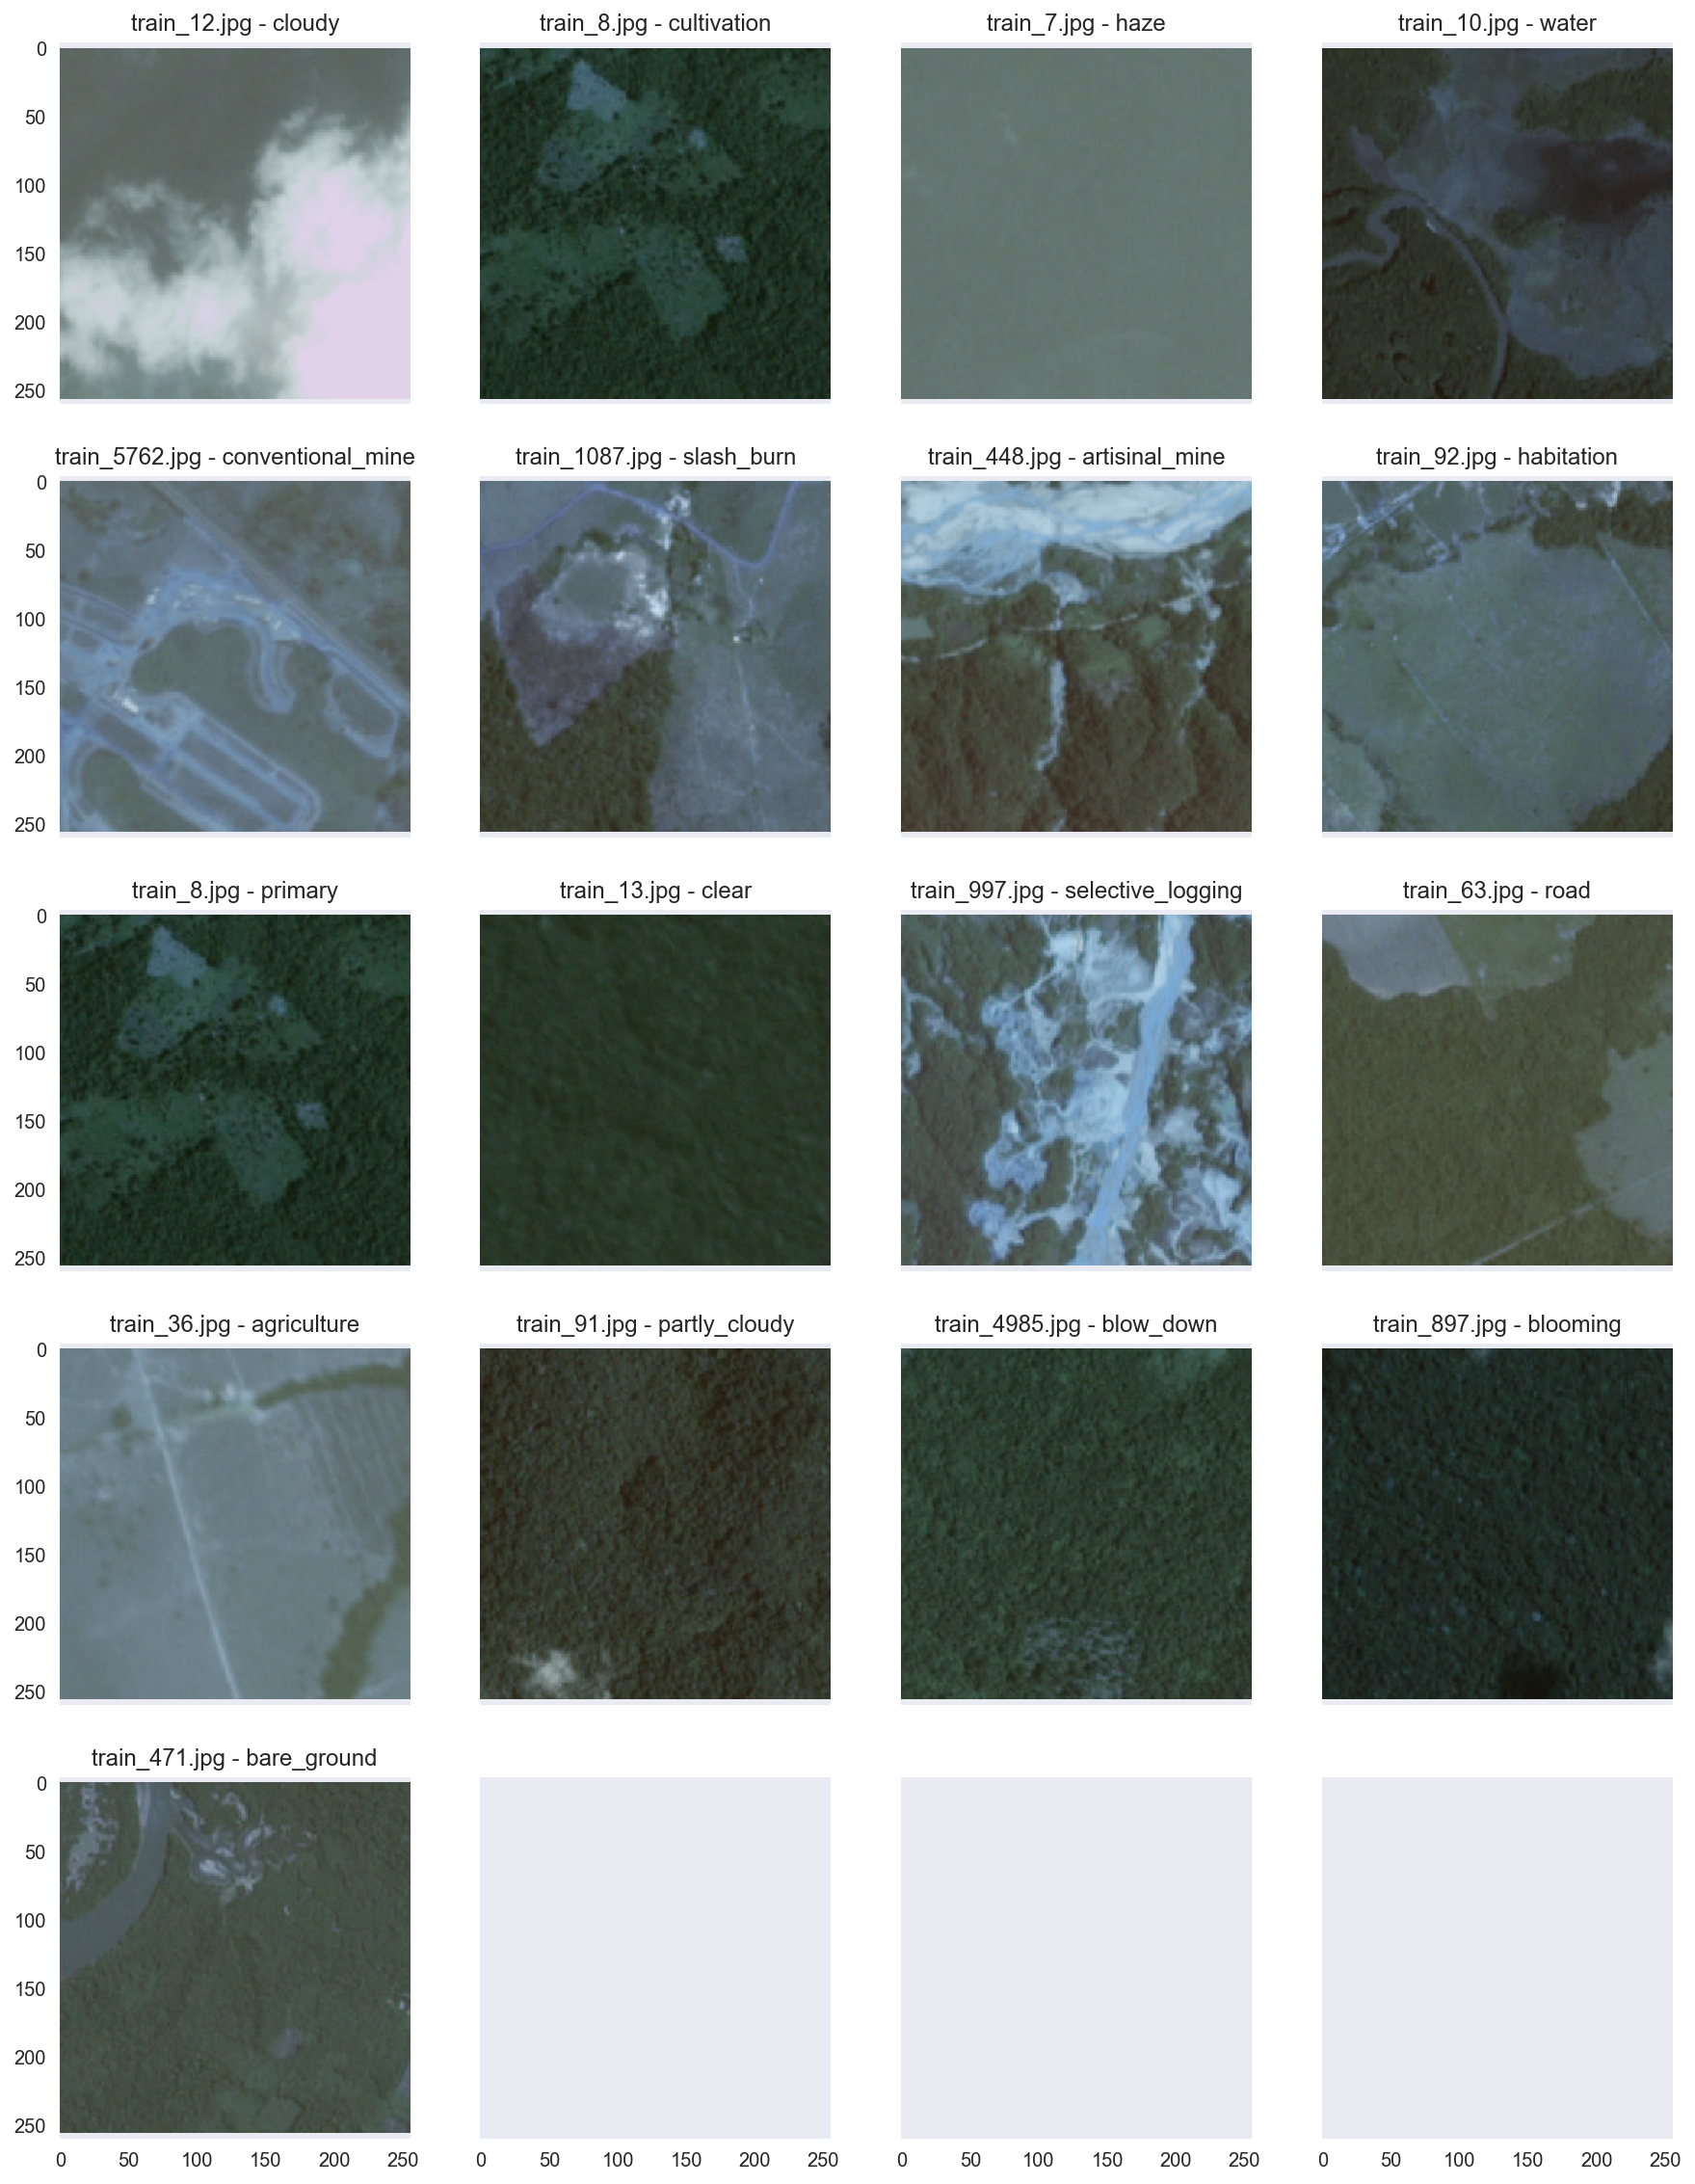

In [7]:
images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = cv2.imread(train_jpeg_dir + '/' + image_name, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title('{} - {}'.format(image_name, label))

# Define hyperparameters
Define the hyperparameters of our neural network

In [ ]:
img_resize = (128, 128) # The resize size of each image
epochs = 15
batch_size = 128

# Data preprocessing
Preprocess the data in order to fit it into the Keras model

In [ ]:
x_train, x_test, y_train, y_map, x_test_filename = data_helper.preprocess_data(train_jpeg_dir, test_jpeg_dir, 
                                                                               test_jpeg_additional, train_csv_file, 
                                                                               img_resize)

Transforming train data to matrices. Using 2 threads...
Transforming test data to matrices. Using 2 threads...


Take a look at our `y_map` and the shape of our train/test sets

In [ ]:
print("x_train shape: {}".format(x_train.shape))
print("x_test  shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
y_map

## Create the neural network definition

In [ ]:
classifier = AmazonKerasClassifier()
classifier.add_conv_layer(img_resize)
classifier.add_flatten_layer()
classifier.add_ann_layer(len(y_map))
train_losses, val_losses, fbeta_score = classifier.train_model(x_train, y_train, epochs, batch_size, train_callbacks=[TQDMNotebookCallback()])

## Monitor the results

Check that we do not overfit by plotting the losses of the train and validation sets

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend();

Look at our fbeta_score

In [ ]:
fbeta_score

Predict the labels of our `x_test` images

In [ ]:
predictions = classifier.predict(x_test)
predictions[:2]

Before mapping our predictions to their appropriate labels we need to figure out what threshold to take for each class.

To do so we will take the median value of each classes.

In [ ]:
# For now we'll just put all thresholds to 0.2 
thresholds = [0.2] * len(labels_set)

# TODO complete
tags_pred = np.array(predictions).T
medians = [0] * len(labels_set)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, tag_vals in enumerate(tags_pred):
    try:
        sns.distplot(tag_vals, ax=axs[i])
    except:
        pass

Now lets map our predictions to their tags and use the thresholds we just retrieved

In [ ]:
predicted_labels = classifier.map_predictions(predictions, y_map, thresholds)

Finally lets assemble and visualize our prediction for the test dataset

In [ ]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test_filename, tags_list)]

In [ ]:
final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
final_df.head()

In [ ]:
tags_s = pd.Series(list(chain.from_iterable(predicted_labels))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=tags_s, y=tags_s.index, orient='h');

If there is a lot of `primary` and `clear` tags, this final dataset may be legit...

And save it to a submission file

In [ ]:
final_df.to_csv('../submission_file.csv', index=False)
classifier.close()

That's it, we're done!